# 6 - GSTools

With version `0.5` `scikit-gstat` offers an interface to the awesome [`gstools`](https://github.com/GeoStat-Framework/GSTools) library. This way, you can use a `Variogram` estimated with `scikit-gstat` in [`gstools`](https://github.com/GeoStat-Framework/GSTools) to perform random field generation, kriging and much, much more.

For a `Variogram` instance, there are two possibilities to export into [`gstools`](https://github.com/GeoStat-Framework/GSTools): 

1. `Variogram.to_empirical(bin_center=True)` returns a pair of distance lag bins and experimental semi-variance values, like [`gstools.variogram.vario_estimate`](https://geostat-framework.readthedocs.io/projects/gstools/en/latest/generated/gstools.variogram.vario_estimate.html). 
2. `Variogram.to_gstools` returns a parameterized `CovModel` of the Variogram. This is not implemented yet.

## 6.1 `to_empirical`

### 6.1.1 Reproducing the gstools example

You can reproduce the [Getting Started example for variogram estimation from GSTools docs](https://geostat-framework.readthedocs.io/projects/gstools/en/latest/index.html#id3) with `scikit-gstat`, and replace the calculation of the empirical variogram with `skg.Variogram`. 

Note: This does only make sense if you want to use a distance metric, binning procedure or semi-variance estimator, that is not included in `gstools` or are bound to `scikit-gstat` for any other reason. `Variogram` will _always_ perform a full model fitting cycle on instantiation, which could lead to some substantial overhead here.
This behavior might change in a future version of `scikit-gstat`.

In [1]:
# import
import skgstat as skg
import gstools as gs
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# use the example from gstools
# generate a synthetic field with an exponential model
x = np.random.RandomState(19970221).rand(1000) * 100.
y = np.random.RandomState(20011012).rand(1000) * 100.
model = gs.Exponential(dim=2, var=2, len_scale=8)
srf = gs.SRF(model, mean=0, seed=19970221)
field = srf((x, y))

# combine x and y for use in skgstat
coords = np.column_stack((x, y))

In the example, [`gstools.variogram.vario_estimate`](https://geostat-framework.readthedocs.io/projects/gstools/en/latest/generated/gstools.variogram.vario_estimate.html) is used to estimate the empirical variogram:

```Python
# estimate the variogram of the field
bin_center, gamma = gs.vario_estimate((x, y), field)
```

Here, we can use `skg.Variogram`. From the shown arguments, `estimator` and `bin_func` are using the default values:

In [3]:
V = skg.Variogram(coords, field, n_lags=21, estimator='matheron', maxlag=45, bin_func='even')
bin_center, gamma = V.get_empirical(bin_center=True) 

And finally, the exact same code from the GSTools docs can be called:

Stable(dim=2, var=1.8664381760010573, len_scale=7.551138734097058, nugget=0.0, anis=[1.], angles=[0.], alpha=1.0796318192255687)


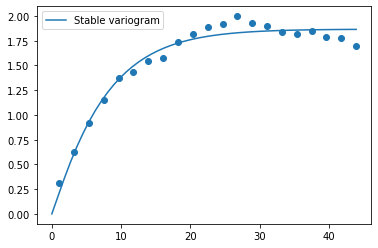

In [4]:
%matplotlib inline
# fit the variogram with a stable model. (no nugget fitted)
fit_model = gs.Stable(dim=2)
fit_model.fit_variogram(bin_center, gamma, nugget=False)
# output
ax = fit_model.plot(x_max=max(bin_center))
ax.scatter(bin_center, gamma)
print(fit_model)

### 6.1.2 Using other arguments

Now, with the example [from the GSTools docs](https://geostat-framework.readthedocs.io/projects/gstools/en/latest/index.html#id3) working, we can start chaning the arguments to create quite different empirical variograms. 

**Note**: This should just illustrate the available possibilities, the result is by no means producing a better estimate of the initially created Gaussian random field. 

In this example different things will be changed:

- use only 15 lag classes, but distribute the point pairs equally. Note the differing widths of the classes. (`bin_func='uniform'`)
- The [Dowd](https://mmaelicke.github.io/scikit-gstat/reference/estimator.html#dowd) estimator is used. (`estimator='dowd'`)
- The [Taxicab metric](https://en.wikipedia.org/wiki/Taxicab_geometry) (aka. Manhattan metric or cityblock metric) is used over Euklidean for no obvious reason. (`dist_func='cityblock'`)

In [5]:
V = skg.Variogram(coords, field, n_lags=15, estimator='dowd', maxlag=45, bin_func='uniform', dist_func='cityblock')
bin_center, gamma = V.get_empirical(bin_center=True) 

Stable(dim=2, var=2.65938343984757, len_scale=17.28936695845174, nugget=1.4232259877071614, anis=[1.], angles=[0.], alpha=1.9999999999999991)


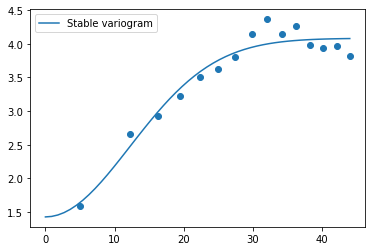

In [6]:
# fit the variogram with a stable model. (no nugget fitted)
fit_model = gs.Stable(dim=2)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# output
ax = fit_model.plot(x_max=max(bin_center))
ax.scatter(bin_center, gamma)
print(fit_model)

If you fit the `gs.Stable` with a nugget, it fits quite well. But keep in mind that this does not necessarily describe the original field very well and was just fitted for demonstration.